In [94]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
import re
from sklearn.preprocessing import Imputer
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt 
%matplotlib inline 

In [19]:
#Let's load the data 
proteomes= pd.read_csv("77_cancer_proteomes_CPTAC_itraq.csv",header=0, index_col = 0) 
clin_df= pd.read_csv("clinical_data_breast_cancer.csv",header=0, index_col= 0)
pam50  = pd.read_csv("PAM50_proteins.csv", header= 0 , index_col=  0) 



These data sets ca be found in pyblic data store of at https://eww/kaggle.com/piotrgrablo/breastcancerproteomes

In summary, these data sets constititute the body of published iTRAQ proteome profiling of 77 breast cancer samples generated by the clinical Proteomic Tumor Analysis Consortium. According to the source, it contains values for ~12000 proteins for each sample.

Brief Description of the data Frames:

(1) The proteomes data frames comtains the Reference Seques protein ID which is unique for each protein, a unique symbol to each gene (gene_symbol) and  full name of that gene (gene_name column). These to colmns are useless so we can drop them out. 
*Important Note: The last tree columns in the data frame belongto healthy people.

(2) Clin_df : the first column "Complete TCGA ID" is used to match the sample IDs in the proteomes file. All other colums contain data about the cancer classification via difereten existing methods.For this analysis we will use the "PAM50 mRNA" classification.

(3) pam50: this data frame contains the list of genes and proteins used by the PAM50 classification system.  This file also contains the RefSeqProteinID to be matched with the proteomes data frame.





In [20]:
#let's look at proteomes 
#let's drop the gene_symbol and gene_name column since they are useless 
proteomes = proteomes.drop(['gene_symbol','gene_name'],axis=1)
proteomes_trans = proteomes.transpose()
proteomes.head()



,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,A2-A0EX.04TCGA,AO-A12D.05TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,1.185108,1.100688,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,1.192612,1.100688,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,1.188860,1.100688,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,1.185108,1.100688,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,1.200116,1.093358,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In [21]:
#let's look at the clinical data
clin_df.head()

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0T2,FEMALE,66,Negative,Negative,Negative,T3,T_Other,N3,Positive,M1,...,Basal-like,0,-13,3,5,Basal,3,2,2,2
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18V,FEMALE,48,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A0E0,FEMALE,38,Negative,Negative,Negative,T3,T_Other,N3,Positive,M0,...,Basal-like,0,-13,5,5,Basal,1,2,2,2


In [22]:
#let's change the column names of the proteomes files 
tmp_col = proteomes.columns.tolist()

new_col = []
for col in tmp_col:
    new_name =None ;
   
    if bool(re.search("TCGA",col)):
        new_name = "TCGA-%s" % (re.split('[_|-|.]',col)[0])
        
    else:
        new_name = col
    
    new_col.append(new_name)




In [23]:
proteomes.columns = [new_col]
proteomes = proteomes.transpose()

Observation: The first colums is the matching IDs of the proteins. One can notice that both files , proteomes and clin_df, show diffent format for matching IDs. We need to transform one of the columns so we can do some matching.

In [24]:
#we need to drop clinical samples that are not part of the proteomes data
#this routine helps to find the match in the clinical data

match_list = proteomes.index.tolist() #proteins name list
ids = []
for idx, index in enumerate(clin_df.index):
    
    #if index is in the protein list then add the idx to the ids list
    if index in match_list:
        ids.append(idx)
        
#extract the matches   
clin_df  = clin_df.iloc[ids]




In [25]:

clin_proteomes = proteomes.merge(clin_df,left_index=True,right_index=True)
(clin_proteomes.head())

RefSeq_accession_number,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.652150,-0.984373,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.097512,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.512473,...,Basal-like,-12,-13,4,5,Basal,3,2,2,2
TCGA-A2-A0EQ,-0.912670,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.071151,-2.278943,...,HER2-enriched,-5,-2,5,4,Basal,4,4,1,1
TCGA-A2-A0EV,0.452986,0.472590,0.472590,0.458587,0.472590,0.472590,0.472590,0.472590,-0.742871,1.811277,...,Luminal A,-4,0,4,2,ReacI,3,3,3,4
TCGA-A2-A0EX,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,...,Luminal A,-7,-5,4,4,ReacI,4,3,1,4


In [26]:
#Now we want to use the sample tha mathc the 
processed = clin_proteomes.loc[:,[x for x in clin_proteomes if bool(re.search("NP_|XP_",x)) ==True]]
processed.head()

RefSeq_accession_number,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,...,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.652150,-0.984373,...,NaN,NaN,1.153614,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.097512,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.512473,...,0.919136,-1.648856,0.832649,NaN,-8.324969,-4.679219,NaN,-1.106650,NaN,-6.941181
TCGA-A2-A0EQ,-0.912670,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.071151,-2.278943,...,-0.801685,NaN,NaN,3.802310,-6.373934,-1.123160,NaN,NaN,NaN,NaN
TCGA-A2-A0EV,0.452986,0.472590,0.472590,0.458587,0.472590,0.472590,0.472590,0.472590,-0.742871,1.811277,...,-4.966177,-1.471027,NaN,-0.474013,-12.278546,-10.337729,-0.653251,NaN,NaN,NaN
TCGA-A2-A0EX,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,...,1.451490,-2.018981,0.877456,NaN,NaN,-6.101005,NaN,-1.726336,NaN,NaN


In [68]:
 ## Select only the PAM50 proteins - known panel of genes used for breast cancer subtype prediction
processed_p50 = clin_proteomes.ix[:,clin_proteomes.columns.isin(pam50['RefSeqProteinID'])]


In [59]:

 
## Impute missing values (maybe another method would work better?)
imputer = Imputer(missing_values='NaN', strategy='mean', axis=1)
imputer = imputer.fit(processed_p50)
processed_numerical_data = imputer.transform(processed_p50)


In [76]:

#function to create random numeraical data 
def create_random_data(percentile):
    if percentile-1.0 > 1e-15:
        raise RuntimeError("arg should be less than 1 and more than 0")
        
    nbr_col = processed_numerical_data.shape[1]
    nbr_data = int(percentile * nbr_col)
    rand_col = np.random.choice(range(nbr_col),nbr_data)
    rand_processed_p50 = processed_p50.iloc[:,rand_col]
    rand_num_processed_p50 = imputer.transform(rand_processed_p50)
    
    return rand_num_processed_p50;




In [91]:

def compare_k_means(k_list,data):
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = KMeans(n_clusters=k, n_jobs=100)
        clusterer.fit(data)
        
        print("Silhouette Coefficient for k == %s: %s" % (
        k, round(metrics.silhouette_score(data, clusterer.labels_), 100)))
        
        ## The higher (up to 1) the better
        print("Homogeneity score for k == %s: %s" % (
        k, round(metrics.homogeneity_score(clin_proteomes['PAM50 mRNA'], clusterer.labels_),10)))
        print(" ")
        
 

In [92]:

#let's create a random set that contains 0.9
n_cluster =[2,3,4,5]
percentile =range(4,9)

for i in percentile:
    
    true_per = i*0.1;
    print("************percentile: %s"%true_per )
    random_prot_data = create_random_data(true_per)
    compare_k_means(n_cluster,random_prot_data)
    print(" ")


percentile

************percentile: 0.4
Silhouette Coefficient for k == 2: 0.241952239909
Homogeneity score for k == 2: 0.2944262008
 
Silhouette Coefficient for k == 3: 0.159872241943
Homogeneity score for k == 3: 0.3985255635
 
Silhouette Coefficient for k == 4: 0.132478099267
Homogeneity score for k == 4: 0.4386118908
 
Silhouette Coefficient for k == 5: 0.144954111301
Homogeneity score for k == 5: 0.3961501074
 
 
************percentile: 0.5
Silhouette Coefficient for k == 2: 0.270078341158
Homogeneity score for k == 2: 0.1936078321
 
Silhouette Coefficient for k == 3: 0.22405664144
Homogeneity score for k == 3: 0.4238154496
 
Silhouette Coefficient for k == 4: 0.183352048106
Homogeneity score for k == 4: 0.4618390661
 
Silhouette Coefficient for k == 5: 0.175707107361
Homogeneity score for k == 5: 0.4065972739
 
 
************percentile: 0.6
Silhouette Coefficient for k == 2: 0.199115516481
Homogeneity score for k == 2: 0.1820576596
 
Silhouette Coefficient for k == 3: 0.192683385962
Homogene

[4, 5, 6, 7, 8]

#One Can see that cluster 2 or 3 are the best options

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


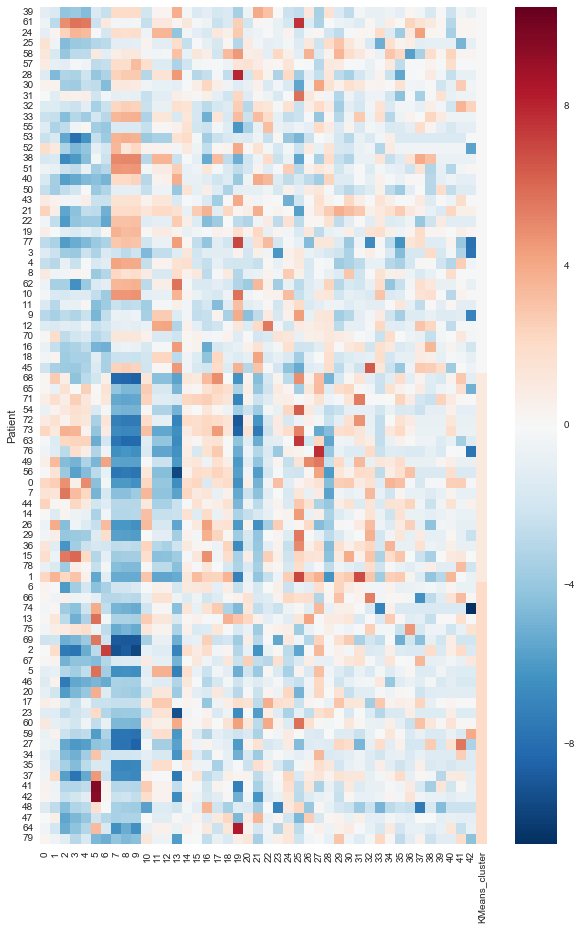

In [102]:
#One Can Plot a heatmap of the coordinates and cluster
clusterer_final = KMeans(n_clusters=3, n_jobs=10)
clusterer_final = clusterer_final.fit(processed_numerical_data)
processed_p50_plot = pd.DataFrame(processed_numerical_data)
processed_p50_plot['KMeans_cluster'] = clusterer_final.labels_
processed_p50_plot.sort('KMeans_cluster',axis=0,inplace=True)

## Look at the heatmap of protein expression in all patients and look at their assigned cluster
## Proteins can either be more expressed (more is produced, less degraded), not changed or lower expressed than the used reference
## Since each protein has a distinct function in the cell, their levels describe the functional/signaling state the cell is in.
processed_p50_plot.index.name = 'Patient'
fig, ax = plt.subplots(figsize=(10,15))
sb.heatmap(processed_p50_plot) ## The x